
# Generalized Frangi with Multi‑modal Fusion on FIND

This notebook illustrates all steps with formulas and figures. We use Greek letters for clarity:
- Σ: set of scales, σ: a single scale
- λ₁, λ₂: Hessian eigenvalues sorted so that |λ₁| ≤ |λ₂|
- β, c, c_θ: Frangi hyper‑parameters
- R: pixel neighborhood radius; K ∈ {1,2} controls triangle‑connectivity


In [1]:

# Install runtime deps (Colab-friendly)
!pip -q install numpy scipy scikit-image matplotlib joblib tqdm tqdm-joblib hdbscan networkx gdown tifffile imageio pandas Pillow pot


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.1 MB/s eta 0:00:00


In [2]:
%%bash
git clone https://github.com/Ludwig-H/Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset.git
cd Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset
pip install  .
cd ..

Processing /content/Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for frangi-fusion: filename=frangi_fusion-0.1.0-py3-none-any.whl size=17626 sha256=e9336df6663b0b03c0a5ed0e17637e613558aad71b9ec59a1ff95319fea9600d
  Stored in directory: /root/.cache/pip/wheels/cf/4d/0b/07f466e36f5ccb3bee5b5dd1c8bb8f8557c5e10cfde7e5996b
Successfully built frangi-fusion


Cloning into 'Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset'...


In [3]:

import os, sys, numpy as np, matplotlib.pyplot as plt, random, zipfile, imageio, pandas as pd
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed

# Ensure local src is importable in Colab
repo_root = os.path.abspath("..")
if repo_root not in sys.path:
    sys.path.append(repo_root)

from frangi_fusion import (
    set_seed, auto_discover_find_structure, load_modalities_and_gt_by_index, to_gray_uint8,
    to_gray, compute_hessians_per_scale, fuse_hessians_per_scale,
    build_frangi_similarity_graph, distances_from_similarity, triangle_connectivity_graph,
    largest_connected_component, hdbscan_from_sparse,
    mst_on_cluster, kcenters_on_tree, paths_between_centers, skeleton_from_center_paths,
    overlay_hessian_orientation, show_clusters_on_image, animate_fault_growth,
    skeletonize_lee, thicken, jaccard_index, tversky_index, wasserstein_distance_skeletons
)


/usr/local/lib/python3.12/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm



## 1) Download FIND via `gdown` then unzip

We fetch `data.zip` and unpack to `data_find/`.


In [4]:

import gdown, zipfile, os
url = "https://drive.google.com/uc?id=1qnLMCeon7LJjT9H0ENiNF5sFs-F7-NvK"
zip_path = "data.zip"
if not os.path.exists(zip_path):
    gdown.download(url, zip_path, quiet=False)

extract_dir = "data_find"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(extract_dir)
print("Unzipped to:", extract_dir)


Downloading...
From (original): https://drive.google.com/uc?id=1qnLMCeon7LJjT9H0ENiNF5sFs-F7-NvK
From (redirected): https://drive.google.com/uc?id=1qnLMCeon7LJjT9H0ENiNF5sFs-F7-NvK&confirm=t&uuid=2c6ba2e1-026e-44f0-a491-931c31a0414f
To: /content/data.zip
100%|██████████| 1.15G/1.15G [00:06<00:00, 181MB/s]


Unzipped to: data_find



## 2) Pick one image and show modalities

We discover the folder structure and select one index with a fixed seed for reproducibility.


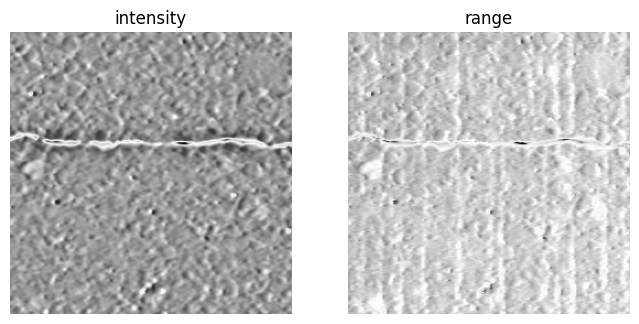

In [5]:

set_seed(42)
struct = auto_discover_find_structure("data_find")
n_total = len(struct["label"]) if struct["label"] else len(struct["intensity"])
index = random.Random(7).randrange(max(1, n_total))
dat = load_modalities_and_gt_by_index(struct, index)

# Display modalities
cols = len(dat["arrays"])
plt.figure(figsize=(4*cols,4))
for i,(k,arr) in enumerate(dat["arrays"].items()):
    plt.subplot(1, cols, i+1); plt.title(k); plt.imshow(arr, cmap='gray'); plt.axis('off')
plt.show()
base = dat["arrays"].get("intensity", next(iter(dat['arrays'].values())))



## 3) Parameters

- Σ = {σᵢ}: set of Gaussian scales  
- β, c, c_θ: Frangi parameters  
- R: radius for pixel graph  
- K ∈ {1,2}: 1 = plain Frangi distances; 2 = add triangle‑connectivity (Rips)


In [6]:

Σ = [5]
β = 0.5
c = 0.25
c_θ = 0.125
R = 5
K = 1
expZ = 2.0
dark_ridges = False  # cracks are valleys => λ2 ≥ 0 after our sign convention



## 4) Hessian per modality and per scale

For a grayscale image $I$, the Hessian at scale σ is:
$$
H_\sigma(I) =
\begin{pmatrix}
I_{xx} & I_{xy} \\\\
I_{xy} & I_{yy}
\end{pmatrix}
$$
with Gaussian derivatives and reflective borders.

We sort eigenvalues by absolute value at each pixel: $|\lambda_1| \le |\lambda_2|$.  
**Normalization:** for each σ we divide by $\max_{x,y} |\lambda_2(x,y)|$ so that $\lambda_1,\lambda_2 \in [-1,1]$.


In [7]:

mods = {}
if "intensity" in dat["arrays"]:
    mods["intensity"] = compute_hessians_per_scale(to_gray(dat["arrays"]["intensity"]), Σ)
if "range" in dat["arrays"]:
    mods["range"] = compute_hessians_per_scale(to_gray(dat["arrays"]["range"]), Σ)
# if "fused" in dat["arrays"]:
#     mods["fused"] = compute_hessians_per_scale(to_gray(dat["arrays"]["fused"]), Σ)

weights = {k:1.0 for k in mods.keys()}
fused_H = fuse_hessians_per_scale(mods, weights)
print("Modalities fused:", list(mods.keys()))


Modalities fused: ['intensity', 'range']



### Visualize: orientation-colored overlays and $|\lambda_2|$

We show θ (color hue) and strength (value). For $|\lambda_2|$ we select, per pixel, the σ that maximizes $|\lambda_2|$.


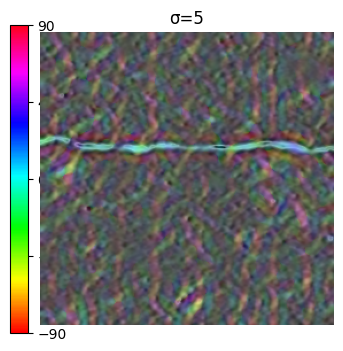

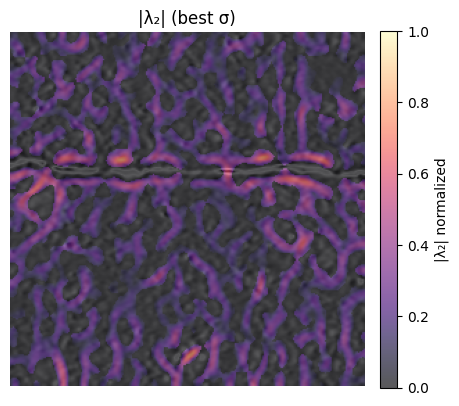

In [8]:

# Single legend at left + 4 overlays
import matplotlib as mpl
fig = plt.figure(figsize=(16,4))
gs = fig.add_gridspec(nrows=1, ncols=5, width_ratios=[0.06,1,1,1,1], wspace=0.05)
cax = fig.add_subplot(gs[0,0])
sm = mpl.cm.ScalarMappable(cmap=mpl.cm.hsv, norm=mpl.colors.Normalize(vmin=-90, vmax=90))
cb = fig.colorbar(sm, cax=cax); cb.set_label("θ (deg)", fontsize=9); cb.set_ticks([-90,-45,0,45,90])
for i,Hd in enumerate(fused_H[:4]):
    ax = fig.add_subplot(gs[0,i+1])
    overlay = overlay_hessian_orientation(base, Hd, alpha=0.5)
    ax.imshow(overlay); ax.set_title(f"σ={Hd['sigma']}"); ax.axis('off')
plt.show()

# |λ2| at best scale
e2n_stack = np.stack([Hd['e2n'] for Hd in fused_H], axis=0)
abs_e2n_stack = np.abs(e2n_stack)
best_idx = abs_e2n_stack.argmax(axis=0)
e2n_best = np.take_along_axis(e2n_stack, best_idx[None,...], axis=0)[0]
plt.figure(figsize=(5,5)); plt.imshow(base, cmap='gray'); im=plt.imshow(np.clip(e2n_best,0,1), cmap='magma', alpha=0.65, vmin=0, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label="|λ₂| normalized"); plt.axis('off'); plt.title("|λ₂| (best σ)"); plt.show()



/tmp/ipython-input-1103364467.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


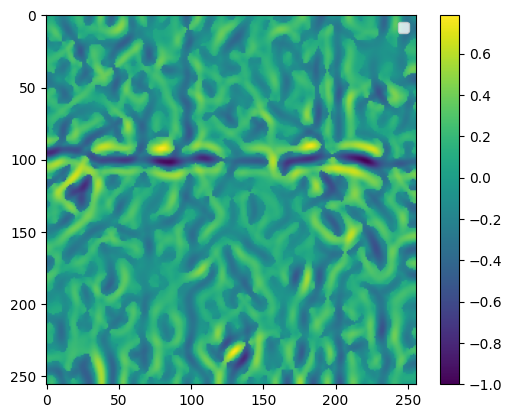

In [9]:
plt.imshow(fused_H[0]['e2n'])
plt.colorbar()
plt.legend()


## 5) Frangi similarity graph $S$

For neighbor pixels $i,j$ within radius $R$, we define a similarity (Frangi‑style):
$$
s(i,j)=\exp\!\left(-\tfrac12 \big(\tfrac{R_i+R_j}{\beta}\big)^2\right)\,
\Big(1-\exp\!\left(-\tfrac12 \big(\tfrac{|\\lambda_{2,i}\\lambda_{2,j}|}{c}\big)^2\right)\Big)\,
\exp\!\left(-\tfrac12 \big(\tfrac{|\sin(\theta_i-\theta_j)|}{c_\\theta}\big)^2\right)
$$
We keep only valleys if `dark_ridges=True` (λ₂ ≥ 0).
Distances are $D = 1 - S$.


In [10]:

coords, neighbors, S = build_frangi_similarity_graph(fused_H, β, c, c_θ, R, candidate_mask=None, dark_ridges=dark_ridges)
D = distances_from_similarity(S)
print("Graph:", D.shape, "nnz:", D.nnz)


Graph: (3277, 3277) nnz: 69162



## 6) Optional triangle‑connectivity ($K=2$)

We connect edges via Vietoris–Rips triangles (filtration = max of edge distances).


In [11]:

if K==2:
    D = triangle_connectivity_graph(coords, D)
    print("After triangle‑connectivity:", D.shape, "nnz:", D.nnz)



## 7) Largest connected component


In [12]:

D_cc, idx_nodes = largest_connected_component(D)
sub_coords = coords[idx_nodes]
print("Largest CC:", D_cc.shape[0], "nodes")


Largest CC: 580 nodes



## 8) Sparse HDBSCAN on CSR distances (no densification)

We compute **core distances** from sparse neighbors, **mutual reachability**, the **MST**, and apply a simplified **EOM** selection.


Clusters: [0]


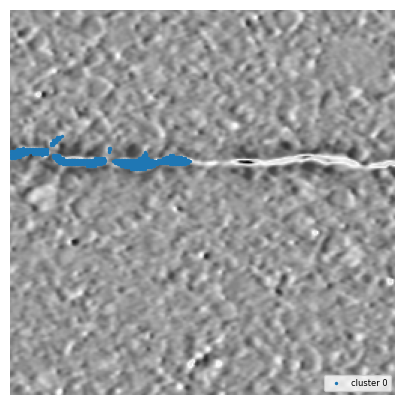

In [13]:

labels = hdbscan_from_sparse(D_cc, min_cluster_size=50, min_samples=1, allow_single_cluster=True, expZ=expZ)
print("Clusters:", np.unique(labels))
show_clusters_on_image(base, sub_coords, labels, figsize=(5,5))



## 9) MST + k‑centers + exact MST paths → skeleton

We set \(k = \\max(3, N/100)\) where \(N\) is the number of nodes in a cluster. The final skeleton is the union of all MST paths between the k‑centers.


In [14]:

from frangi_fusion.mst_kcenters import mst_on_cluster, kcenters_on_tree, paths_between_centers, skeleton_from_center_paths
all_fault_edges = []
uniq = np.unique(labels)
for lab in uniq:
    if lab < 0: continue
    cl = np.where(labels==lab)[0]
    if cl.size < 3: continue
    mst = mst_on_cluster(D_cc, cl)
    k = max(3, int(cl.size/100))
    centers = kcenters_on_tree(mst, k, objective="max")
    paths = paths_between_centers(mst, centers)
    segs = skeleton_from_center_paths(paths, sub_coords[cl], mst)
    if segs.shape[0]>0: all_fault_edges.append(segs)
fault_edges = np.vstack(all_fault_edges) if all_fault_edges else np.zeros((0,5), dtype=np.float32)
print("Skeleton segments:", fault_edges.shape)


Skeleton segments: (504, 5)



### Visualize skeleton on the base image


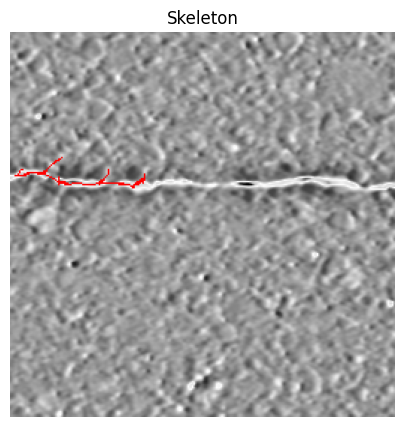

In [15]:

H,W = base.shape[:2]
overlay = np.dstack([base,base,base]).astype(np.float32)
for e in fault_edges:
    r0,c0,r1,c1,w = e
    rr = np.linspace(r0, r1, num=int(max(abs(r1-r0),abs(c1-c0))+1)).astype(int)
    cc = np.linspace(c0, c1, num=rr.shape[0]).astype(int)
    rr = np.clip(rr, 0, H-1); cc = np.clip(cc, 0, W-1)
    overlay[rr,cc,0]=255; overlay[rr,cc,1]=0; overlay[rr,cc,2]=0
plt.figure(figsize=(5,5)); plt.imshow(overlay.astype(np.uint8)); plt.axis('off'); plt.title("Skeleton"); plt.show()



## 10) Filtration per pixel

For each pixel \(i\) in the CC, the filtration value is \(\min_j d(i,j)\) over its neighbors.


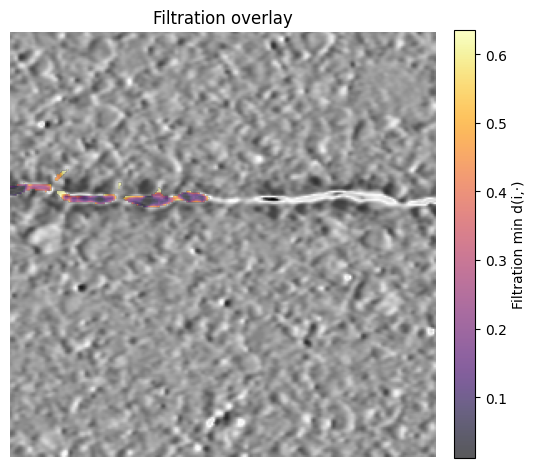

In [16]:

n = D_cc.shape[0]
indptr, indices, data = D_cc.indptr, D_cc.indices, D_cc.data
filtration = np.full(n, np.inf, dtype=np.float64)
for i in range(n):
    row = data[indptr[i]:indptr[i+1]]
    if row.size>0: filtration[i] = float(row.min())
fmap = np.full(base.shape[:2], np.nan, dtype=np.float32)
rr,cc = sub_coords[:,0], sub_coords[:,1]
fmap[rr,cc] = filtration.astype(np.float32)
vmin = np.nanpercentile(fmap,5); vmax = np.nanpercentile(fmap,95)
plt.figure(figsize=(6,6)); plt.imshow(base, cmap='gray')
im = plt.imshow(np.ma.masked_invalid(fmap), cmap='inferno', alpha=0.65, vmin=vmin, vmax=vmax)
plt.colorbar(im, fraction=0.046, pad=0.04, label="Filtration min d(i,·)")
plt.axis('off'); plt.title("Filtration overlay"); plt.show()



## 11) Thresholded graph (τ = 0.3) and metrics vs GT

We thicken fragments to compare skeletons more robustly. Metrics: **Jaccard**, **Tversky** (α=1, β=0.5), **Wasserstein**.


Jaccard: 0.0 Tversky: 0.0 Wasserstein: 700.0


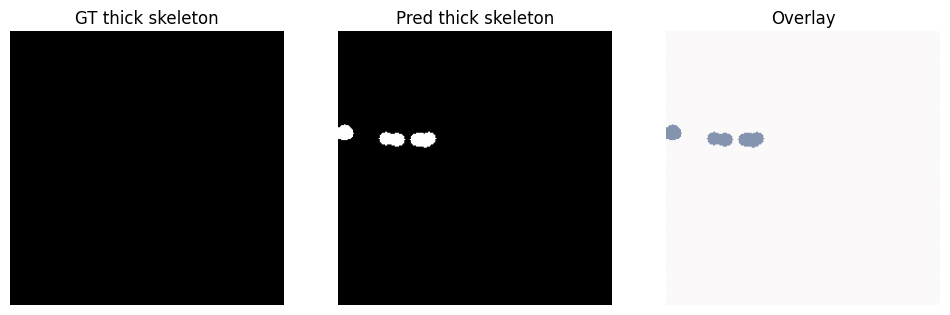

In [17]:

tau = 0.3
mask = np.zeros_like(base, dtype=np.uint8)
for e in fault_edges[fault_edges[:,-1] <= tau]:
    r0,c0,r1,c1,w = e
    rr = np.linspace(r0, r1, num=int(max(abs(r1-r0),abs(c1-c0))+1)).astype(int)
    cc = np.linspace(c0, c1, num=rr.shape[0]).astype(int)
    rr = np.clip(rr, 0, base.shape[0]-1); cc = np.clip(cc, 0, base.shape[1]-1)
    mask[rr,cc] = 1

sk_pred = skeletonize_lee(mask); sk_pred = thicken(sk_pred, pixels=6)
gt = (dat["arrays"].get("label", np.zeros_like(base)) > 0).astype(np.uint8)
sk_gt = skeletonize_lee(gt); sk_gt = thicken(sk_gt, pixels=6)

jac = jaccard_index(sk_pred, sk_gt)
tvs = tversky_index(sk_pred, sk_gt, alpha=1.0, beta=0.5)
wass = wasserstein_distance_skeletons(sk_pred, sk_gt)
print("Jaccard:", jac, "Tversky:", tvs, "Wasserstein:", wass)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("GT thick skeleton"); plt.imshow(sk_gt, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title("Pred thick skeleton"); plt.imshow(sk_pred, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title("Overlay");
plt.imshow(sk_gt*255, cmap='Reds', alpha=0.7); plt.imshow(sk_pred*255, cmap='Blues', alpha=0.5); plt.axis('off')
plt.show()
